In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData, check_fluxbalance, alpha_HS04
from mhsflex.field3d import Field3dData, calculate_magfield, j3d, lf3d
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type NOTICE
 - 1 are of type VERSION
 - 29 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

In [5]:
data_bz = data["b2dz5"]
data_bx = data["b2dx5"]
data_by = data["b2dy5"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 40.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 40.0 * 10**-3
pixelsize_y_Mm = 40.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 4000.0 * 10**-3

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

x_arr = np.arange(nresol_x) * (xmax_Mm) / (nresol_x - 1) - xmax_Mm/2
y_arr = np.arange(nresol_y) * (ymax_Mm) / (nresol_y - 1) - xmax_Mm/2 

x_arr = np.arange(nresol_x) * (xmax_Mm) / (nresol_x - 1) 
y_arr = np.arange(nresol_y) * (ymax_Mm) / (nresol_y - 1)
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)


xmax_Mm, ymax_Mm, zmax_Mm 3.2 3.2 4.0
nresol_x, nresol_y, nresol_z 80 80 100
pixelsize_x 0.04
pixelsize_y 0.04
pixelsize_z 0.04


In [8]:
alpha_HS04(data_bx, data_by, data_bz) / 0.04 

-0.946507416665554

In [26]:
print(data_bz.min())
print(data_bz.max())

-1792.2522
446.3689


In [9]:
alpha = -0.94
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm

length_scale_x_norm = length_scale_x / length_scale 
length_scale_y_norm = length_scale_y / length_scale 

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = 1 / 2 * (1 - alpha**2 / k2_arr)

print(limit.min())

from scipy.special import jv

# for z in z_arr:
#     print(jv(p, q * np.exp(- z * 0.02 / 2.0)))

# for ix in range(nf_max):
#     for iy in range(nf_max):
#         if jv(p, q)[iy, ix] != 0: print(iy, ix, " : p ", p[iy, ix], " : q ", q[iy, ix])

0.2708098614620937


In [11]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [10]:
b = 1.0
aL = 0.0
aMHS = 0.27
data3dP = calculate_magfield(data2d, aL, b, 0.0, 2.0, 0.2)
data3dL = calculate_magfield(data2d, aL, b, alpha, 2.0, 0.2)
data3dMHS = calculate_magfield(data2d, aMHS, b, alpha, 2.0, 0.2)

NameError: name 'data2d' is not defined

NameError: name 'folder' is not defined

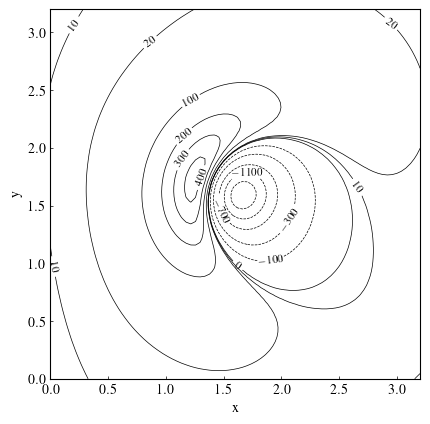

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1500, -1100, -700, -300, -100, 0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

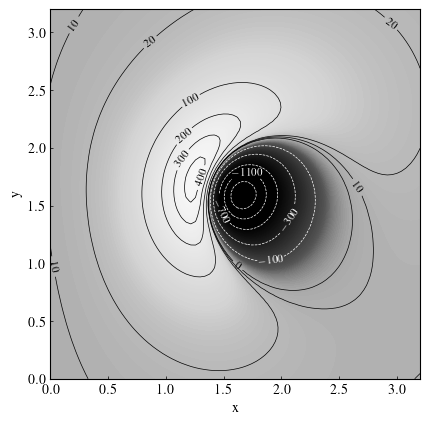

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(
    x_grid,
    y_grid,
    data2d.bz,
    1000,
    cmap=cmap, 
    norm=norm,
)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1500, -1100, -700, -300, -100)),
    colors="white",
    linewidths=0.5,
)
CS2 = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.clabel(CS2, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  folder + "/contourcombi.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

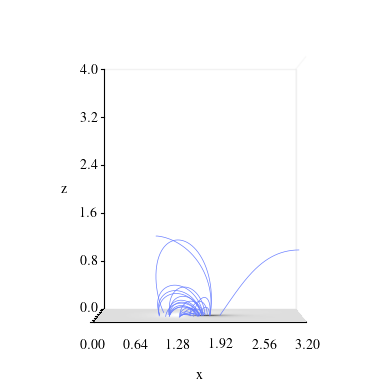

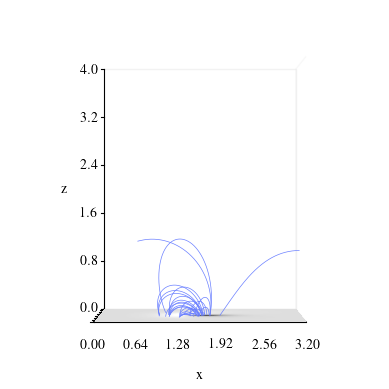

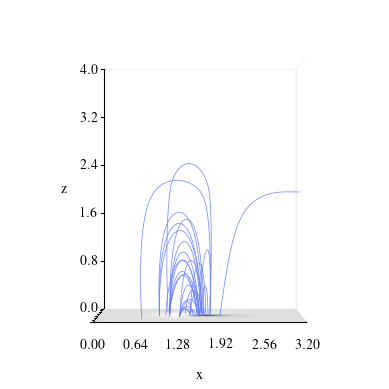

In [48]:
plot(data3dP, "side")
plot(data3dL, "side")
plot(data3dMHS, "side")

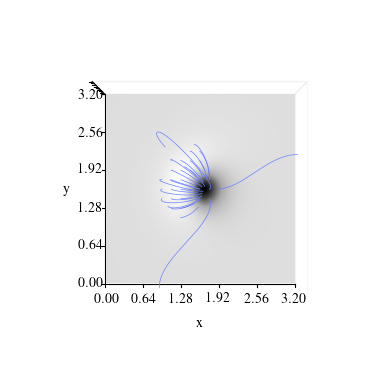

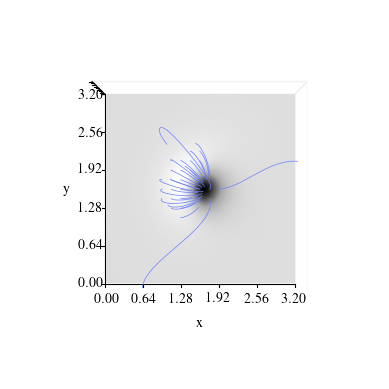

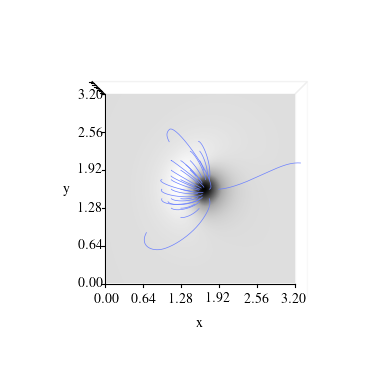

In [49]:
plot(data3dP, "los")
plot(data3dL, "los")
plot(data3dMHS, "los")

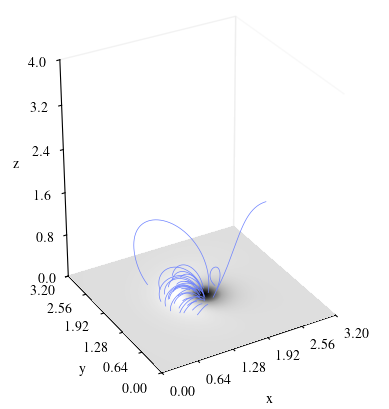

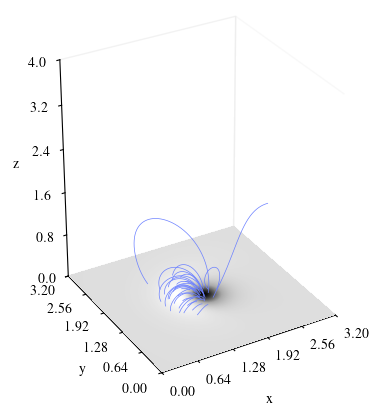

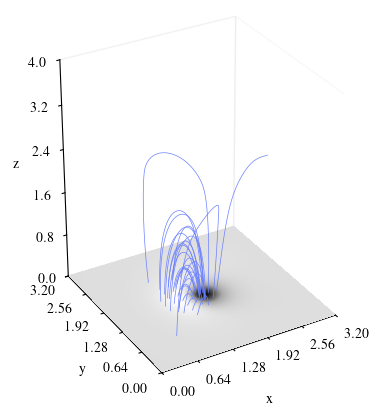

In [44]:
plot(data3dP, "angular")
plot(data3dL, "angular")
plot(data3dMHS, "angular")

In [50]:
T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data2d.bz.max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

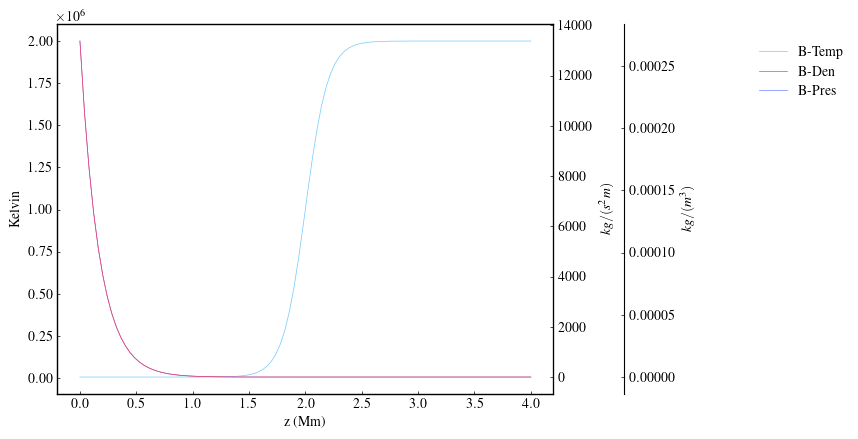

In [60]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.set_ylabel("Kelvin")
ax2.set_ylabel(r"$kg/(s^2 m)$")
ax3.set_ylabel(r"$kg /(m^3)$")

ax1.set_xlabel("z (Mm)")

ax1.plot(
    data2d.z,
    data3dP.btemp,
    linewidth=0.5,
    color=c1,
    label=r"B-Temp",
    linestyle="solid",
)

ax2.plot(
    data2d.z,
    BETA0 / 2.0 * data3dP.bpressure * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    color=c2,
    label=r"B-Pres",
    linestyle="solid",
)

ax3.plot(
    data2d.z,
    BETA0
    / (2.0 * H)
    * T0
    / T_PHOTOSPHERE
    * data3dP.bdensity
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    color=c4,
    label=r"B-Den",
    linestyle="solid",
)

# ax1.plot(
#     data2d.z,
#     backtemp,
#     linewidth=0.5,
#     color=c1,
#     label=r"B-Temp linear",
# )

# ax2.plot(
#     data2d.z,
#     BETA0 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
#     linewidth=0.5,
#     color=c2,
#     label=r"B-Pres linear",
# )

# ax3.plot(
#     data2d.z,
#     BETA0
#     / (2.0 * H)
#     * T0
#     / T_PHOTOSPHERE
#     * backden
#     * (B0 * 10**-4) ** 2.0
#     / (MU0 * G_SOLAR * L),
#     linewidth=0.5,
#     color=c4,
#     label=r"B-Den linear",
# )


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()

lines = lines4 + lines1 + lines3 + lines2
labels = labels4 + labels1 + labels3 + labels2
plt.legend(lines, labels, frameon=False, loc="center", bbox_to_anchor=(1.5, 0.87))

ax3.spines["right"].set_position(("outward", 51))
ax4.get_yaxis().set_visible(False)

ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
ax3.tick_params(direction="in", length=2, width=0.5)
ax4.tick_params(direction="in", length=2, width=0.5)
#plotname = folder + "/batm_tanh.png"
#plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

NameError: name 'folder' is not defined

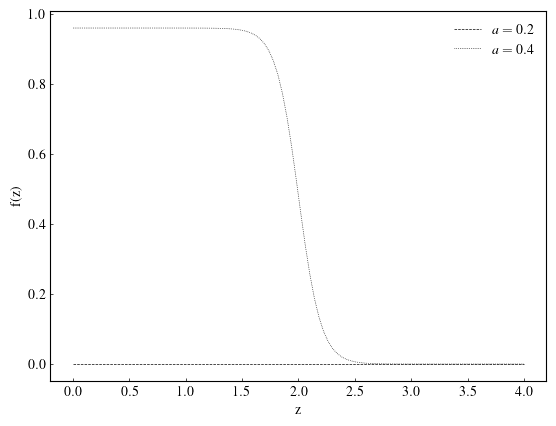

In [66]:
from mhsflex.switch import f
deltaz = 0.2
f2 = f(z_arr, z0, deltaz, aL, b)
f3 = f(z_arr, z0, deltaz, aMHS, b)


plt.plot(
    z_arr,
    f2,
    label=r"$a =0.2$",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    f3,
    label=r"$a =0.4$",
    linewidth=0.5,
    color="black",
    linestyle="dotted",
)
plt.legend(frameon=False)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/f.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
compare_field3d(data3dL, data3dMHS)

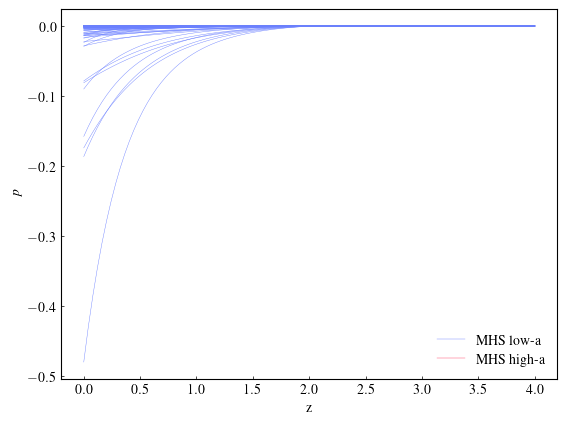

In [67]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA"
plt.plot(
    z_arr,
    data3dMHS.dpressure[0, 0, :],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="MHS low-a",
)
plt.plot(
    z_arr,
    data3dL.dpressure[0, 0, :],
    linewidth=0.3,
    color=c4,
    # linestyle="dashed",
    label="MHS high-a",
)
# for ix in range(40, 50, 3):
#     for iy in range(40, 50, 3):
for ix in range(1, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        plt.plot(
            z_arr,
            data3dMHS.dpressure[iy, ix, :],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.ylabel("$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/dpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA"
plt.plot(
    z_arr,
    data3dm1.ddensity[0, 0, :],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="MHS low-a",
)
plt.plot(
    z_arr,
    data3dm2.ddensity[0, 0, :],
    linewidth=0.3,
    color=c4,
    # linestyle="dashed",
    label="MHS high-a",
)
# for ix in range(40, 50, 3):
#     for iy in range(40, 50, 3):
for ix in range(0, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        plt.plot(
            z_arr,
            data3dm1.ddensity[iy, ix, :],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
        plt.plot(
            z_arr,
            data3dm2.ddensity[iy, ix, :],
            linewidth=0.3,
            color=c4,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.plot(
    z_arr,
    data3dlff.ddensity[0, 0, :],
    linewidth=0.3,
    color="black",
    label="LFF",
)
plt.ylabel("$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/dden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()